In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize,stats
import seaborn as sns
from matplotlib.ticker import MultipleLocator
url='https://raw.githubusercontent.com/rossetl/Earthquake-Data-Analysis/main/SouthCalifornia-1982-2011_Physics-of-Data.dat'
labels=['#', 'pointer','t', 'mag', 'lat', 'long', 'dep']
df=pd.read_csv(url,sep="\s",names=labels,engine='python') 
df=df.drop(columns=['#'])
c=60*60*24

# $P_{m,R}(t)$ 

C:\Users\andre\anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
C:\Users\andre\anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


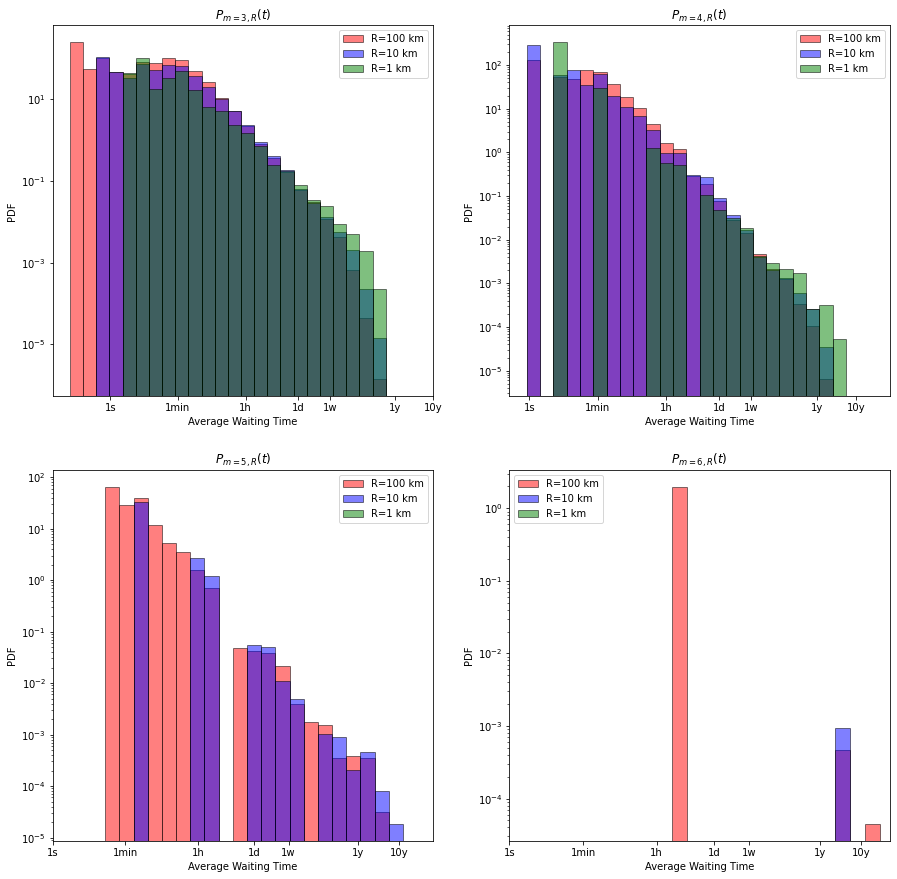

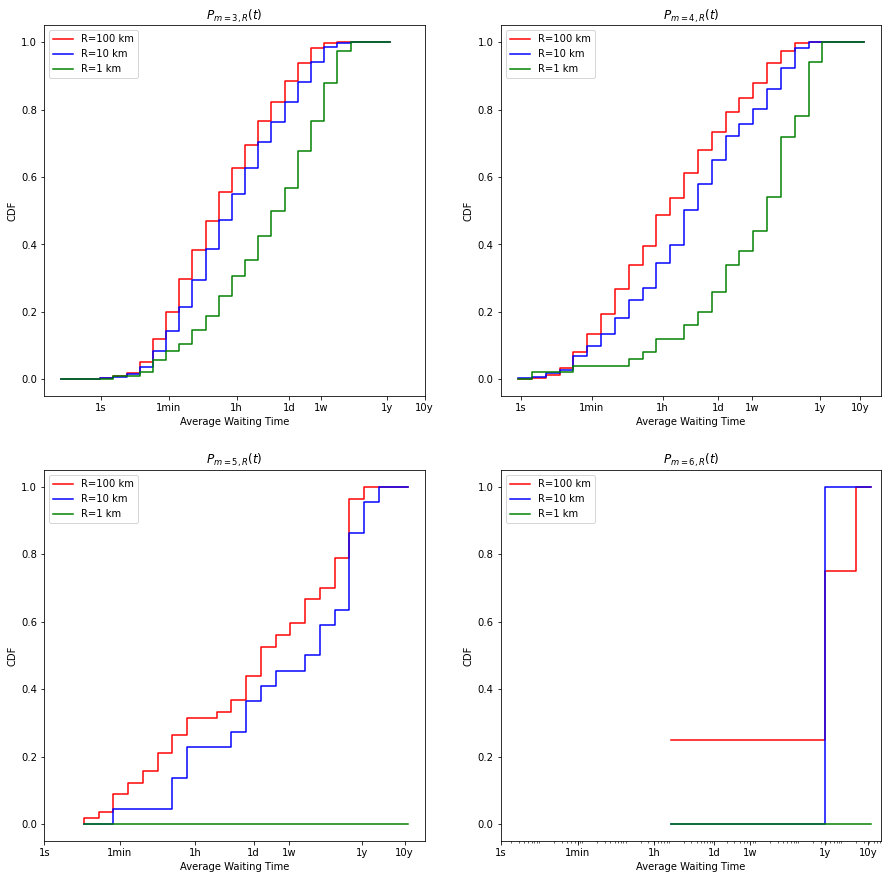

In [2]:
magth=np.arange(3,7,1)
extmv0=np.array([-6,-5,-4,-1])
extmv1=np.array([3,4,4,4])
ncpd=4 #number of class per decade
num_bins=np.array([9,9,8,5])*(ncpd-1) 
R=np.matrix('100000 100000 100000 100000;10000 10000 10000 10000;1000 1000 1000 1000')
l=np.shape(R)[0]
colors=['red','blue','green']

def p(i,j):
    if i==1 and j==0:
     p=2
    elif i==1 and j==1:
     p=3
    else:
     p=i+j
    return p
    
fig0, axs = plt.subplots(2,2,figsize=(15,15))
fig1, axt = plt.subplots(2,2,figsize=(15,15))

for i in range(2):
    for j in range(2):
        for z in range(l):
            mask=df['mag']>=magth[p(i,j)]
            dr=df[mask]
            dr=dr.drop(columns=['t','pointer','mag'])
            dr['dpw']=((dr.diff()**2).sum(axis=1))**0.5 #dpw stay  for distance pairs waise
            dr=dr.drop(dr[dr['dpw'] > R[z,p(i,j)]].index)
            dr.insert(loc=0, column='t', value=df['t'][dr.index].diff())
            dr=dr.drop(columns=['lat','long','dep'])
            dr.insert(loc=2, column='mag', value=df['mag'][dr.index])
            dr['t'][dr['t'].index[0]]=0
            
            hcounts, hbins, hbars =axs[i,j].hist(dr['t']/c, alpha=0.5,color=colors[z],edgecolor='black',density=1,
                                                 bins=np.logspace(extmv0[p(i,j)],extmv1[p(i,j)],num_bins[p(i,j)]),
                                                 label='R=%.0f km'%(R[z,p(i,j)]/1000))
            axs[i,j].set_xscale('log')
            axs[i,j].set_yscale('log')
            axs[i,j].set_xticks([1/c,60/c,1/24,1,7,365, 3650])
            axs[i,j].set_xticklabels(['1s','1min','1h','1d','1w','1y','10y'])
            axs[i,j].set_title('$P_{m= %.0f,R} (t)$' % magth[p(i,j)] )
            axs[i,j].set_xlabel('Average Waiting Time')
            axs[i,j].set_ylabel('PDF')
            
            cnt, edges = np.histogram(dr['t']/c, bins=hbins)
            if np.sum(cnt)!=0:
                y=cnt.cumsum()/np.sum(cnt)
            else:
                y=np.zeros(len(cnt))
                
            axt[i,j].set_xscale('log')    
            axt[i,j].step(edges[:-1],y,label='R=%.0f km'%(R[z,p(i,j)]/1000),color=colors[z])
            axt[i,j].set_xticks([1/c,60/c,1/24,1,7,365, 3650])
            axt[i,j].set_xticklabels(['1s','1min','1h','1d','1w','1y','10y'])
            axt[i,j].set_title('$P_{m= %.0f,R} (t)$' % magth[p(i,j)] )
            axt[i,j].set_xlabel('Average Waiting Time')
            axt[i,j].set_ylabel('CDF')
            
        axs[i,j].legend()
        axt[i,j].legend(loc='upper left')

Quando si computa Pm,R stiamo selezionando eventi sismici con una magnitudo oltre una certa soglia MA dentro una certa soglia di distanza. Si sono prima selezionati tutti gli eventi con m>mth e poi si è filtrato in base alla distanza. Questo vuol dire che in un qualche modo stiamo cercando la distribuzione dei tempi che si manifestino terremoti importanti ma che siano "vicini" entro una certa soglia. Se infatti aumentiamo R stiamo considerando la distribuzione dei tempi fra due terremoti importanti in qualsiasi punto della mappa, ma se restringiamo R vuol dire che in un qualche senso stiamo "forzando una causalità" fra i terremoti, siamo interessati alla PDF del tempo che dopo un terremoto importante se ne verifichi un altro, ugualmente importante, entro una certa distanza. Ovviamente ci stiamo riferendo a una distanza fra ipocentri, che può essere poi proiettata a epicentri, in modo che diventi fruibile per la popolazione. L'idea di evoluzione temporale è verificata dal grafico qui sotto.

# M vs pointer=-1 PDF (Original Study)

---Fit Parameters with Errors---
a=2.19 +-0.03
b=-1.03 +-0.01
r=-0.9987


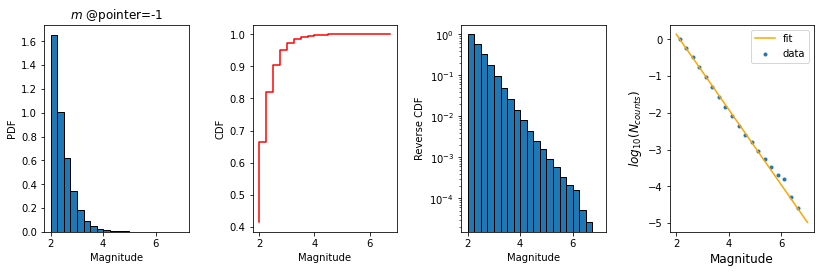

In [3]:
fig0, axs = plt.subplots(1,4,figsize=(12,4))
fig0.tight_layout(pad=3.0)

counts, bins, bars = axs[0].hist(df['mag'][df['pointer']==-1], bins=np.linspace(2,7,25-4),edgecolor='black',density=1)
axs[0].set_xlabel('Magnitude')
axs[0].set_ylabel('PDF')
axs[0].set_title('$m$ @pointer=-1')

axs[1].step(bins[:-1],counts.cumsum()/np.sum(counts),color='red')
axs[1].set_xlabel('Magnitude')
axs[1].set_ylabel('CDF');

counts, bins, bars = axs[2].hist(df['mag'][df['pointer']==-1], bins=np.linspace(2,7,25-4),edgecolor='black',
                                 density='cumulative',cumulative=-1)
axs[2].set_yscale('log')
axs[2].set_xlabel('Magnitude')
axs[2].set_ylabel('Reverse CDF')

logmB=np.log10(counts[:-1])
xB=(bins[:-2]+bins[1:-1])/2
def f(x,a,b):
    f=a+b*x
    return f
B=optimize.curve_fit(f,xB,logmB,sigma=counts[:-1]**(-0.5),p0=[6,-1])  #poisson error is assumed
res = stats.linregress(xB, logmB)

xx=np.linspace(2,7,100)
axs[3].plot(xx,f(xx,B[0][0],B[0][1]),'orange',label='fit')
axs[3].scatter(xB,logmB,label='data',linewidths=1,marker='.')
axs[3].set_xlabel('Magnitude',size=12)
axs[3].set_ylabel('$log_{10}(N_{counts})$',size=12)
axs[3].legend();

print('---Fit Parameters with Errors---')
print('a=%.2f'%B[0][0],'+-%.2f'%B[1][0,0]**0.5)
print('b=%.2f'%B[0][1],'+-%.2f'%B[1][1,1]**0.5)
print('r=%.4f'%res.rvalue)

Questo grafico mostra come i terremoti inidicizzati -1 (generatori) non sono quelli a maggiore terremoto (CDF plot utile se si usa il log-y space), nemmeno se considerassimo i segnali con m=2 come noise. Distribuzione di tipo lineare sull log-y space

# Back-Tree Algorithm

In [4]:
mth=4 #questa soglia selezione quale evento viene considerato importante (che verrà usato nel foreshock)
mask=(df['mag']>=mth) & (df['pointer']!=-1)
i1 = df['pointer'][mask].to_numpy()
origin=0
originv=0
nv=0
for i in range(len(i1)):
    mask1=[]
    mask1=[i1[i]]
    n=0
    while mask1[-1]!=-1:
        i2=df['pointer'][mask1[-1]] 
        mask1.append(i2)
        n=n+1
    nv=np.insert(nv,-1,n) 
    origin=np.insert(origin,-1,mask1[-2])
    originv=np.insert(originv,-1,mask1[:-1])
    
nv=np.delete(nv,-1)        #numero di step prima di arrivare all'evento generatore
origin=np.delete(origin,-1)#indici di riferimento dell'evento generatore
originv=np.unique(np.delete(originv,-1))#tutti gli indici (no doppioni) che portano a ritroso all'evento generatore

# Correlation between Time and Distance (Original Study)

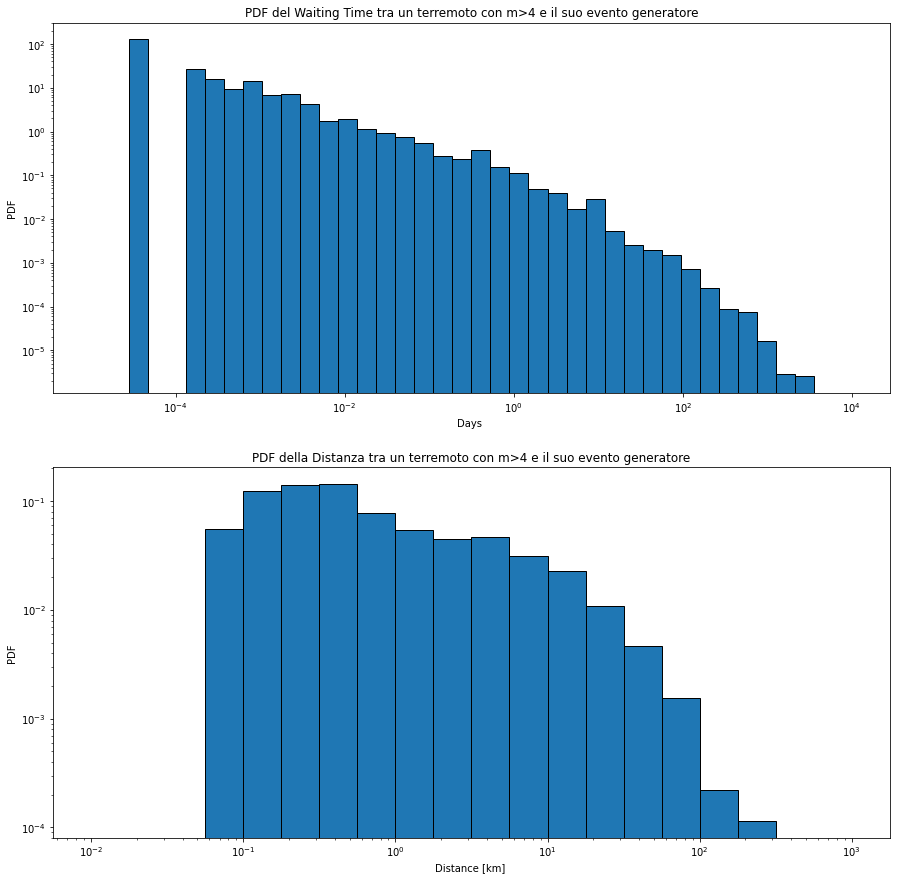

In [5]:
mask=(df['mag']>=mth) & (df['pointer']!=-1)  
i1 = df['pointer'][mask].to_numpy()
dtmc=df['t'][mask].to_numpy()-df['t'][origin].to_numpy()
x1=(df['lat'][mask].to_numpy()-df['lat'][origin].to_numpy())**2
y1=(df['long'][mask].to_numpy()-df['long'][origin].to_numpy())**2
z1=(df['dep'][mask].to_numpy()-df['dep'][origin].to_numpy())**2
drmc=(x1+y1+z1)**0.5

fig0, axs = plt.subplots(2,1,figsize=(15,15))
t1=np.ceil(np.log10(np.max(dtmc)/c))
r1=np.ceil(np.log10(np.max(drmc)/1000))
t0=np.floor(np.log10(np.min(dtmc)/c))
r0=np.floor(np.log10(np.min(drmc)/1000))

counts, bins, bars = axs[0].hist(dtmc/c, bins=np.logspace(t0,t1,(int)(t1-t0)*5-4),edgecolor='black',density=1)
axs[0].set_xlabel('Days ')
axs[0].set_ylabel('PDF')
axs[0].set_title('PDF del Waiting Time tra un terremoto con m>%.0f e il suo evento generatore' %mth)
axs[0].set_xscale('log')
axs[0].set_yscale('log')

counts, bins, bars = axs[1].hist(drmc/1000, bins=np.logspace(r0,r1,(int)(r1-r0)*5-4),edgecolor='black',density=1)
axs[1].set_xlabel('Distance [km] ')
axs[1].set_ylabel('PDF')
axs[1].set_title('PDF della Distanza tra un terremoto con m>%.0f e il suo evento generatore' %mth)
axs[1].set_xscale('log')
axs[1].set_yscale('log')

#LINEAR VERSION 
#counts, bins, bars = axs.hist(dtmc/c, bins=np.linspace(0,t1,70),edgecolor='black',density=1)
#axs.set_xlim(0,t1);
#axs.xaxis.set_minor_locator(MultipleLocator(30))
#axs.set_xticks([7,30*3,30*6,365,365*2])
#axs.set_xticklabels(['1w','3mth','6mth','1y','2y']);

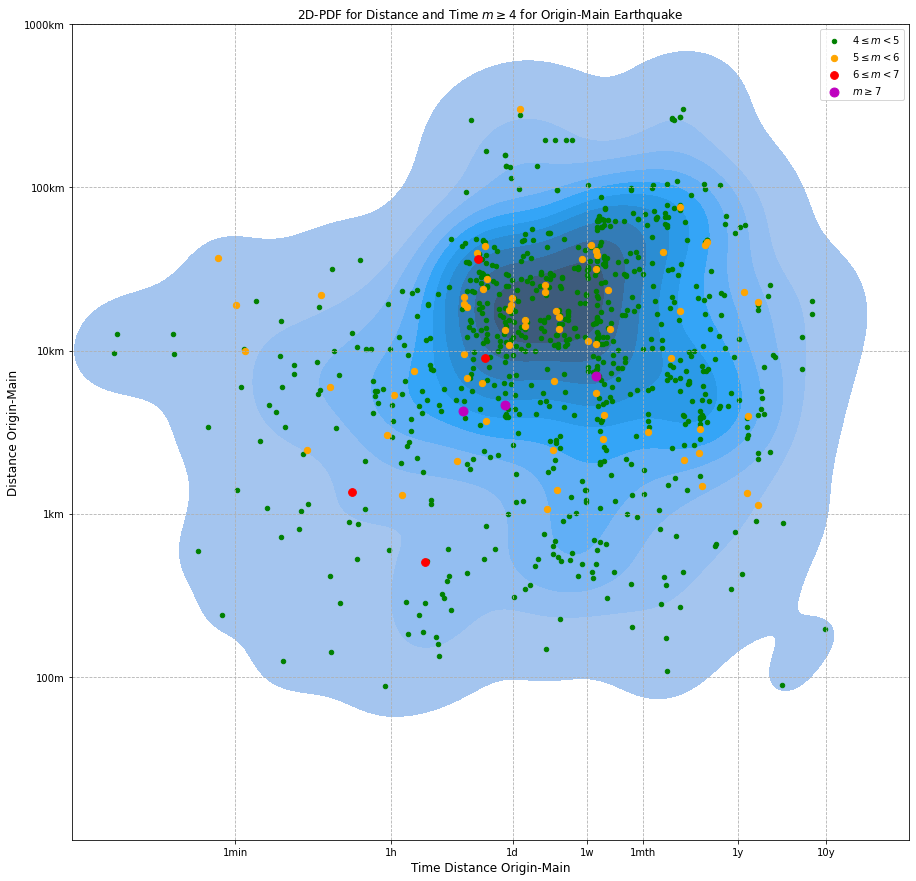

In [6]:
dfr=pd.DataFrame({'dtmc': dtmc/c, 'drmc': drmc/1000,'mag':df['mag'][mask]})
fig0, ax = plt.subplots(figsize=(15,15))
lev=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

sns.kdeplot(x=np.log10(dfr['dtmc']), y=np.log10(dfr['drmc']),fill='true',ax=ax,levels=lev);
ax.set_xlabel('Time Distance Origin-Main',size=12);
ax.set_ylabel('Distance Origin-Main',size=12);
ax.set_title('2D-PDF for Distance and Time $m\geq%.0f$ for Origin-Main Earthquake'%mth)
ax.set_xticks([-3.15,-1.38,0,0.85,1.48,2.56,3.56]) #-3.15 -> 1min  -- -4.93 -> 1sec
ax.set_xticklabels(['1min','1h','1d','1w','1mth','1y','10y']);
ax.set_yticks([-1,0,1,2,3,4])
ax.set_yticklabels(['100m','1km','10km','100km','1000km','10000km'])
ax.set_xlim(-5,4.5);
ax.set_ylim(-2,3);
ax.grid(which='both',b=1, linestyle='dashed')

mthf=6
mask1=(df['mag']<(mthf-1)) & (df['mag']>=(mthf-2)) 
ax.scatter(np.log10(dfr['dtmc'][mask1]),np.log10(dfr['drmc'][mask1]),color='green',
           label=r'$%s\leq m<%s$'%(mthf-2,mthf-1),s=20);

mask1=(df['mag']<mthf) & (df['mag']>=(mthf-1)) 
ax.scatter(np.log10(dfr['dtmc'][mask1]),np.log10(dfr['drmc'][mask1]),color='orange',
           label=r'$%s\leq m<%s$'%(mthf-1,mthf),s=40);

mask1=(df['mag']<(mthf+1)) & (df['mag']>=(mthf)) 
ax.scatter(np.log10(dfr['dtmc'][mask1]),np.log10(dfr['drmc'][mask1]),color='red',
           label=r'$%s\leq m<%s$'%(mthf,mthf+1),s=60);

ax.scatter(np.log10(dfr['dtmc'][dfr['mag']>=(mthf+1)]),np.log10(dfr['drmc'][dfr['mag']>=(mthf+1)]),color='m',
          label='$m\geq%s$'%(mthf+1),s=80);
ax.legend();

# Foreshock Study

---Fit Parameters with Errors 3P---
a=-0.25 +-0.05
b=0.32 +-0.03
c=-0.10 +-0.00
---Fit Parameters with Errors 3P---
a=0.86 $+-0.08
b=-0.36 +-0.03
r=-0.9657


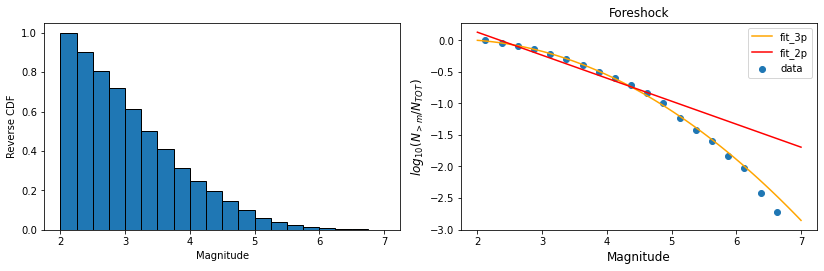

In [7]:
fig0, axs = plt.subplots(1,2,figsize=(12,4))
fig0.tight_layout(pad=3.0)

db=pd.DataFrame({'mag': df['mag'][originv]}) #in origin stiamo consierando terremoti importanti con m>mth
mthu=2 #lower magnitude, we can adjust it (it's difficult to detect small eartquake)
db=db['mag'][db['mag']>mthu]
counts, bins, bars = axs[0].hist(db, bins=np.linspace(mthu,7,25-4),edgecolor='black',density=1,cumulative=-1)
axs[0].set_xlabel('Magnitude')
axs[0].set_ylabel('Reverse CDF')

lim1=1 #<-- has to be set by hand in oder to don't compute log over 0
logmF=np.log10(counts[:len(counts)-lim1])
xF=(bins[:-lim1-1]+bins[1:len(counts)+1-lim1])/2

def f(x,a,b,c):
    f=a+b*x+c*x**2
    return f
F=optimize.curve_fit(f,xF,logmF,sigma=counts[:len(counts)-lim1]**(-0.5),p0=[0.1,0.2,0])  #poisson error is assumed

def q(x,a,b):
    q=a+b*x
    return q
Q=optimize.curve_fit(q,xF,logmF,sigma=counts[:len(counts)-lim1]**(-0.5),p0=[6,-1])  #poisson error is assumed
res = stats.linregress(xF, logmF)

xx=np.linspace(2,7,100)
axs[1].plot(xx,f(xx,F[0][0],F[0][1],F[0][2]),'orange',label='fit_3p')
axs[1].plot(xx,q(xx,Q[0][0],Q[0][1]),'red',label='fit_2p')
axs[1].scatter(xF,logmF,label='data',linewidths=1)
axs[1].set_xlabel('Magnitude',size=12)
axs[1].set_ylabel('$log_{10}(N_{>m} /N_{TOT})$',size=12)
axs[1].set_title('Foreshock')
axs[1].legend();

print('---Fit Parameters with Errors 3P---')
print('a=%.2f'%F[0][0],'+-%.2f'%F[1][0,0]**0.5)
print('b=%.2f'%F[0][1],'+-%.2f'%F[1][1,1]**0.5)
print('c=%.2f'%F[0][2],'+-%.2f'%F[1][2,2]**0.5)
print('---Fit Parameters with Errors 3P---')
print('a=%.2f'%Q[0][0],'$+-%.2f'%Q[1][0,0]**0.5)
print('b=%.2f'%Q[0][1],'+-%.2f'%Q[1][1,1]**0.5)
print('r=%.4f'%res.rvalue)

In [8]:
counts #check here in order to fix lim1 (#of 0 =lim1)

array([1.        , 0.90298507, 0.80503731, 0.71735075, 0.61473881,
       0.50279851, 0.4113806 , 0.31436567, 0.24906716, 0.19869403,
       0.14552239, 0.10074627, 0.05783582, 0.03731343, 0.02518657,
       0.01492537, 0.00932836, 0.00373134, 0.00186567, 0.        ])

# AfterShock Study

---Fit Parameters with Errors---
a=1.88 +-0.02
b=-0.88 +-0.01
r=-0.9944
---Compatibiliy Between Beforeshock and Aftershock Law---
lam_a=9.87
lam_b=11.46


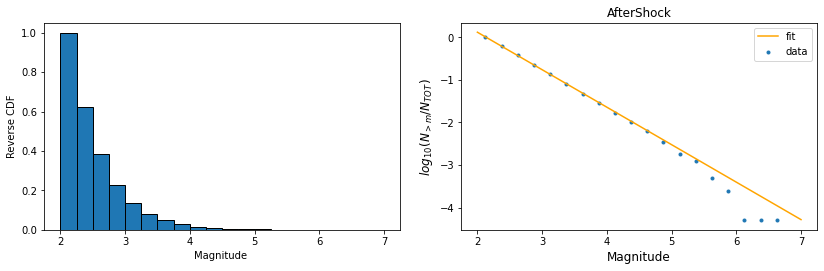

In [9]:
mth=5 #questa è una magnitudo soglia per studiare l'after shock è indipendente dalle scelte precedenti
drf=df['mag'][df['mag']>mth]
i1=drf.index
n=0
for i in range(len(i1)):
    n=np.insert(n,-1,(df['pointer'][df['pointer']==i1[i]].index).to_numpy() )
n=np.delete(n,-1)  

fig0, axs = plt.subplots(1,2,figsize=(12,4))
fig0.tight_layout(pad=3.0)

counts, bins, bars = axs[0].hist(df['mag'][n], bins=np.linspace(2,7,25-4),edgecolor='black',density=1,cumulative=-1)
axs[0].set_xlabel('Magnitude ')
axs[0].set_ylabel('Reverse CDF')

logmA=np.log10(counts[:-1])
xA=(bins[:-2]+bins[1:-1])/2

def f(x,a,b):
    f=a+b*x
    return f
A=optimize.curve_fit(f,xA,logmA,sigma=counts[:-1]**(-0.5),p0=[6,-1])  #poisson error is assumed
res = stats.linregress(xA, logmA)

xx=np.linspace(2,7,100)
axs[1].set_xlabel('Magnitude',size=12)
axs[1].set_ylabel('$log_{10}(N_{>m} /N_{TOT})$',size=12)
axs[1].plot(xx,f(xx,A[0][0],A[0][1]),'orange',label='fit')
axs[1].scatter(xA,logmA,label='data',linewidths=1,marker='.')
axs[1].set_title('AfterShock')
axs[1].legend();

print('---Fit Parameters with Errors---')
print('a=%.2f'%A[0][0],'+-%.2f'%A[1][0,0]**0.5)
print('b=%.2f'%A[0][1],'+-%.2f'%A[1][1,1]**0.5)
print('r=%.4f'%res.rvalue)

print('---Compatibiliy Between Beforeshock and Aftershock Law---')
lam_a=np.abs(A[0][0]-B[0][0])/(A[1][0,0]+B[1][0,0])**0.5
lam_b=np.abs(A[0][1]-B[0][1])/(A[1][1,1]+B[1][1,1])**0.5
print('lam_a=%.2f'%lam_a)
print('lam_b=%.2f'%lam_b)

# Omori-Utsu Law

# Gutenberg–Richter Law 

---Fit Parameters with Errors---
a=2.09 +-0.02
b=-0.98 +-0.01
r=-0.9994


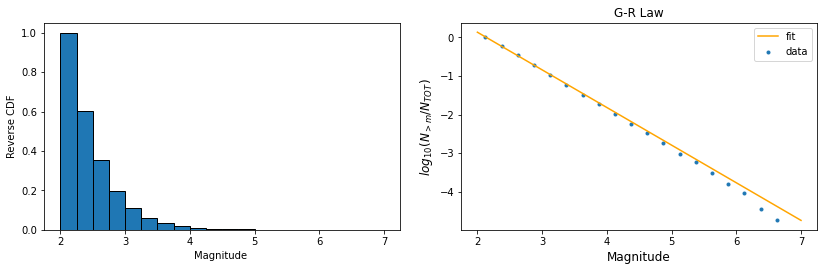

In [10]:
fig0, axs = plt.subplots(1,2,figsize=(12,4))
fig0.tight_layout(pad=3.0)
def f(x,a,b):
    f=a+b*x
    return f
counts, bins, bars = axs[0].hist(df['mag'], bins=np.linspace(2,7,25-4),edgecolor='black',density=1,cumulative=-1)
axs[0].set_xlabel('Magnitude ')
axs[0].set_ylabel('Reverse CDF')

logmG=np.log10(counts[:-1])
xG=(bins[:-2]+bins[1:-1])/2
G=optimize.curve_fit(f,xG,logmG,sigma=counts[:-1]**(-0.5),p0=[6,-1])  #poisson error is assumed
res = stats.linregress(xG, logmG)

xx=np.linspace(2,7,100)
axs[1].set_xlabel('Magnitude',size=12)
axs[1].set_ylabel('$log_{10}(N_{>m} /N_{TOT})$',size=12)
axs[1].plot(xx,f(xx,G[0][0],G[0][1]),'orange',label='fit')
axs[1].scatter(xG,logmG,label='data',linewidths=1,marker='.')
axs[1].set_title('G-R Law')
axs[1].legend();
print('---Fit Parameters with Errors---')
print('a=%.2f'%G[0][0],'+-%.2f'%G[1][0,0]**0.5)
print('b=%.2f'%G[0][1],'+-%.2f'%G[1][1,1]**0.5)
print('r=%.4f'%res.rvalue)

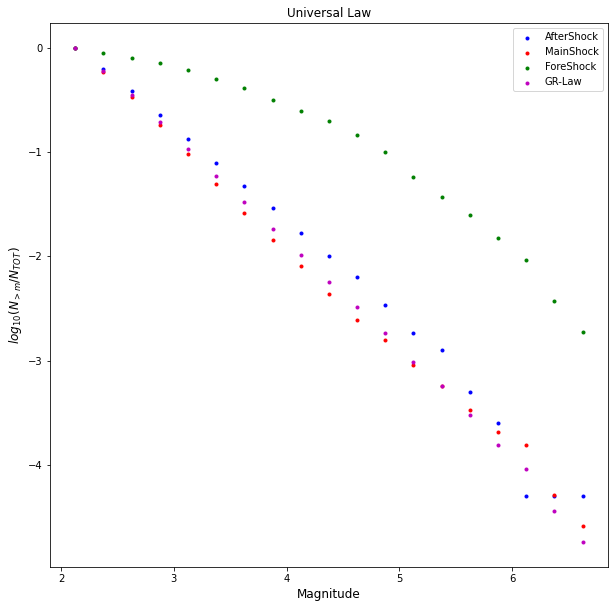

In [11]:
plt.figure(figsize=(10,10))
plt.title('Universal Law')
plt.xlabel('Magnitude',size=12)
plt.ylabel('$log_{10}(N_{>m} /N_{TOT})$',size=12)
plt.scatter(xA,logmA,label='AfterShock',linewidths=1,marker='.',color='blue')
plt.scatter(xB,logmB,label='MainShock',linewidths=1,marker='.',color='red')
plt.scatter(xF,logmF,label='ForeShock',linewidths=1,marker='.',color='green')
plt.scatter(xG,logmG,label='GR-Law',linewidths=1,marker='.',color='m')
plt.legend();

Questa potrebbe essere una proposta di Legge Universale: i punti rossi sono riferiti alla magnitudo dei terremoti che sono etichettati con -1, ovvero sia che non sono originati da un precedente evento; i punti blu sono riferiti alla magnitudo dei terremoti (sciame) che sono avvenuti dopo la verifica di un terremoto importante (m>5); i punti in verde sono riferiti alla magnitudo di quei terremoti che intercedono tra un terremoto importante (m>5) e il suo evento originatore. In magenta la legge di GR (slope -0.98 simile a -0.95 riportato nel paper.)